<a href="https://colab.research.google.com/github/Hamakey/Kaggle_Study/blob/master/realEstatePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title [Necessary] Initial import or settings with connecting your google drive
import requests, bs4
import pandas as pd
from lxml import html
from urllib.parse import urlencode, quote_plus, unquote
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import platform
#에러대응(정규표현식 및 에러메시지)
import traceback
import re
#파일삭제
import glob
import os
#구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

if platform.system() == 'Windows':
    font_name = font_manager.FontPropertise(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family = 'NanumBarunGothic')
else:
    rc('font',family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus']=False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#@title 코랩 폰트설정오류해결 { vertical-output: true }

# print(matplotlib.__version__)
# print(matplotlib.__file__)
# print(matplotlib.get_configdir())
# print(matplotlib.get_cachedir())
sys_font=matplotlib.font_manager.findSystemFonts()
# print(f"sys_font number: {len(sys_font)}")
# print(sys_font)

nanum_font = [f for f in sys_font if 'Nanum' in f]
# print(f"nanum_font number: {len(nanum_font)}")

# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# nanum_font

!python --version
def current_font():
  print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
        
current_font()

path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = matplotlib.font_manager.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
%config InlineBackend.figure_format = 'retina'
matplotlib.font_manager._rebuild()
matplotlib.rcParams['axes.unicode_minus'] = False

Python 3.7.11
설정 폰트 글꼴: ['AppleGothic'], 설정 폰트 사이즈: 10.0
NanumGothic Eco


In [3]:
#@title [Selective] Quantity of APT transaction yearly
#한국부동산원_아파트거래현황 조회 서비스 : 연간 지역별 아파트 거래횟수


def loadTradeCnt(startmonth,endmonth,region):
  url = 'http://openapi.reb.or.kr/OpenAPI_ToolInstallPackage/service/rest/AptTradingStateSvc/getAptTrdStateCaseOfNbr'
  ServiceKey = "HWl55GQ4cyBgljwQ9Xv3ea8ssbyiw6Dm4nouxkeDSlxhPeuwtcTIJ+KlWsWX3NtwqlPqQFpMtweXK2Y7XpOFBQ=="
  queryParams = '?' + urlencode({ quote_plus('ServiceKey') : ServiceKey, quote_plus('startmonth') : startmonth , quote_plus('endmonth') : endmonth, quote_plus('region') : region })
  request = requests.get(url + queryParams).text.encode("utf-8")
  xmlobj = bs4.BeautifulSoup(request, 'lxml-xml')
  rows = xmlobj.findAll('item')
  columns = rows[0].find_all()
  rowList = []
  nameList = []
  columnList = []
  for j in range(len(columns)):
    nameList.append(columns[j].name)
  nameList.append('tradeCnt')
  for date, cnt in map(lambda x : x.split(',') ,columns[2].text.split("|")):
    
    rowList.append([columns[0].text,columns[1].text,date,cnt])
  result = pd.DataFrame(rowList, columns = nameList)
  return result
trade_cnt_per_year = loadTradeCnt(201101,202107,11000)

In [4]:
#@title [Selective] Hashing the code for finding region
#@title

#법정동 코드 해싱
lawd_cd = {
  '서울특별시' : [['강남구', '11680'], ['강동구', '11740'], ['강북구', '11305'], ['강서구', '11500'], ['관악구', '11620'], ['광진구', '11215'], ['구로구', '11530'], ['금천구', '11545'], ['노원구', '11350'], ['도봉구', '11320'], ['동대문구', '11230'], ['동작구', '11590'], ['마포구', '11440'], ['서대문구', '11410'], ['서초구', '11650'], ['성동구', '11200'], ['성북구', '11290'], ['송파구', '11710'], ['양천구', '11470'], ['영등포구', '11560'], ['용산구', '11170'], ['은평구', '11380'], ['종로구', '11110'], ['중구', '11140'], ['중랑구', '11260']] ,
  '부산광역시': [['강서구', '26440'], ['금정구', '26410'], ['기장군', '26710'], ['남구', '26290'], ['동구', '26170'], ['동래구', '26260'], ['부산진구', '26230'], ['북구', '26320'], ['사상구', '26530'], ['사하구', '26380'], ['서구', '26140'], ['수영구', '26500'], ['연제구', '26470'], ['영도구', '26200'], ['중구', '26110'], ['해운대구', '26350']] ,
  '대구광역시': [['남구', '27200'], ['달서구', '27290'], ['달성군', '27710'], ['동구', '27140'], ['북구', '27230'], ['서구', '27170'], ['수성구', '27260'], ['중구', '27110']],
  '인천광역시': [['강화군', '28710'], ['계양구', '28245'], ['남동구', '28200'], ['동구', '28140'], ['미추홀구', '28177'], ['부평구', '28237'], ['서구', '28260'], ['연수구', '28185'], ['옹진군', '28720'], ['중구', '28110']],
  '광주광역시' : [['광산구', '29200'], ['남구', '29155'], ['동구', '29110'], ['북구', '29170'], ['서구', '29140']],
  '대전광역시' : [['대덕구', '30230'], ['동구', '30110'], ['서구', '30170'], ['유성구', '30200'], ['중구', '30140']],
  '울산광역시' : [['남구', '31140'], ['동구', '31170'], ['북구', '31200'], ['울주군', '31710'], ['중구', '31110']],
  '세종특별자치시' : [['세종특별자치시', '36110']],
  '경기도' : [['가평군', '41820'], ['고양시 덕양구', '41281'], ['고양시 일산동구', '41285'], ['고양시 일산서구', '41287'], ['과천시', '41290'], ['광명시', '41210'], ['광주시', '41610'], ['구리시', '41310'], ['군포시', '41410'], ['김포시', '41570'], ['남양주시', '41360'], ['동두천시', '41250'], ['부천시', '41190'], ['성남시 분당구', '41135'], ['성남시 수정구', '41131'], ['성남시 중원구', '41133'], ['수원시 권선구', '41113'], ['수원시 영통구', '41117'], ['수원시 장안구', '41111'], ['수원시 팔달구', '41115'], ['시흥시', '41390'], ['안산시 단원구', '41273'], ['안산시 상록구', '41271'], ['안성시', '41550'], ['안양시 동안구', '41173'], ['안양시 만안구', '41171'], ['양주시', '41630'], ['양평군', '41830'], ['여주시', '41670'], ['연천군', '41800'], ['오산시', '41370'], ['용인시 기흥구', '41463'], ['용인시 수지구', '41465'], ['용인시 처인구', '41461'], ['의왕시', '41430'], ['의정부시', '41150'], ['이천시', '41500'], ['파주시', '41480'], ['평택시', '41220'], ['포천시', '41650'], ['하남시', '41450'], ['화성시', '41590']],
  '강원도' : [['강릉시', '42150'], ['고성군', '42820'], ['동해시', '42170'], ['삼척시', '42230'], ['속초시', '42210'], ['양구군', '42800'], ['양양군', '42830'], ['영월군', '42750'], ['원주시', '42130'], ['인제군', '42810'], ['정선군', '42770'], ['철원군', '42780'], ['춘천시', '42110'], ['태백시', '42190'], ['평창군', '42760'], ['홍천군', '42720'], ['화천군', '42790'], ['횡성군', '42730']],
  '충청북도' : [['괴산군', '43760'], ['단양군', '43800'], ['보은군', '43720'], ['영동군', '43740'], ['옥천군', '43730'], ['음성군', '43770'], ['제천시', '43150'], ['증평군', '43745'], ['진천군', '43750'], ['청주시 상당구', '43111'], ['청주시 서원구', '43112'], ['청주시 청원구', '43114'], ['청주시 흥덕구', '43113'], ['충주시', '43130']],
  '충청남도' : [['계룡시', '44250'], ['공주시', '44150'], ['금산군', '44710'], ['논산시', '44230'], ['당진시', '44270'], ['보령시', '44180'], ['부여군', '44760'], ['서산시', '44210'], ['서천군', '44770'], ['아산시', '44200'], ['예산군', '44810'], ['천안시 동남구', '44131'], ['천안시 서북구', '44133'], ['청양군', '44790'], ['태안군', '44825'], ['홍성군', '44800']],
  '전라북도': [['고창군', '45790'], ['군산시', '45130'], ['김제시', '45210'], ['남원시', '45190'], ['무주군', '45730'], ['부안군', '45800'], ['순창군', '45770'], ['완주군', '45710'], ['익산시', '45140'], ['임실군', '45750'], ['장수군', '45740'], ['전주시 덕진구', '45113'], ['전주시 완산구', '45111'], ['정읍시', '45180'], ['진안군', '45720']],
  '전라남도' : [['강진군', '46810'], ['고흥군', '46770'], ['곡성군', '46720'], ['광양시', '46230'], ['구례군', '46730'], ['나주시', '46170'], ['담양군', '46710'], ['목포시', '46110'], ['무안군', '46840'], ['보성군', '46780'], ['순천시', '46150'], ['신안군', '46910'], ['여수시', '46130'], ['영광군', '46870'], ['영암군', '46830'], ['완도군', '46890'], ['장성군', '46880'], ['장흥군', '46800'], ['진도군', '46900'], ['함평군', '46860'], ['해남군', '46820'], ['화순군', '46790']],
  '경상북도' : [['경산시', '47290'], ['경주시', '47130'], ['고령군', '47830'], ['구미시', '47190'], ['군위군', '47720'], ['김천시', '47150'], ['문경시', '47280'], ['봉화군', '47920'], ['상주시', '47250'], ['성주군', '47840'], ['안동시', '47170'], ['영덕군', '47770'], ['영양군', '47760'], ['영주시', '47210'], ['영천시', '47230'], ['예천군', '47900'], ['울릉군', '47940'], ['울진군', '47930'], ['의성군', '47730'], ['청도군', '47820'], ['청송군', '47750'], ['칠곡군', '47850'], ['포항시 남구', '47111'], ['포항시 북구', '47113']],
  '경상남도' : [['거제시', '48310'], ['거창군', '48880'], ['고성군', '48820'], ['김해시', '48250'], ['남해군', '48840'], ['밀양시', '48270'], ['사천시', '48240'], ['산청군', '48860'], ['양산시', '48330'], ['의령군', '48720'], ['진주시', '48170'], ['창녕군', '48740'], ['창원시 마산합포구', '48125'], ['창원시 마산회원구', '48127'], ['창원시 성산구', '48123'], ['창원시 의창구', '48121'], ['창원시 진해구', '48129'], ['통영시', '48220'], ['하동군', '48850'], ['함안군', '48730'], ['함양군', '48870'], ['합천군', '48890']],
  '제주특별자치도' : [['서귀포시', '50130'], ['제주시', '50110']]
}
lawd = {}
for city, datas in lawd_cd.items():
  lawd[city] = {}
  for sub, cd in datas:
    lawd[city][sub] = cd

In [28]:
#@title [Selective] Getting transaction data for the APT(rent)
#한국부동산원_아파트거래현황 조회 서비스 : 국토교통부_아파트 전월세 자료
def loadAPTTradeData(LAWD_CD, DEAL_YMD):
  # 개선필요 1. 기간조회기능 추가 필요(2021.07.28 기록)
  # 개선필요 2. 중복조회 방지기능 추가 필요(2021.07.28기록)
  #           2-1. 1단계 : 파일명 비교
  #           2-2. 2단계 : 파일 내용 비교하여 업데이트 이력이 없다면 업데이트하지않고 pass(그러면 기준을 어떻게 세워야 일일히 안읽고 할 수 있을지 고민필요)
  url = 'http://openapi.molit.go.kr:8081/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptRent'
  serviceKey = 'HWl55GQ4cyBgljwQ9Xv3ea8ssbyiw6Dm4nouxkeDSlxhPeuwtcTIJ+KlWsWX3NtwqlPqQFpMtweXK2Y7XpOFBQ=='

  urlParams = '?' + urlencode({ quote_plus('serviceKey') : serviceKey, quote_plus('LAWD_CD') : LAWD_CD, quote_plus('DEAL_YMD') : DEAL_YMD})
  request = requests.get(url + urlParams).text.encode('utf-8')
  xmlobj = bs4.BeautifulSoup(request,'lxml-xml')
  rows = xmlobj.findAll('item')
  columns = rows[0].find_all()
  nameList = []
  res = []
  for i in range(len(columns)):
    nameList.append(columns[i].name)
  for j in range(len(rows)):
    rowList = []
    for k in rows[j]:
      if ',' in k.text.strip(): # strip은 데이터에 공백이 좌측에 들어가있으며, 우측또한 있을 경우 에러를 유발하므로 strip
        replacedK = k.text.strip().replace(',','') #보증금액은 , 가 string으로 들어가있어서 처리필요
        rowList.append(replacedK)
      else:
        rowList.append(k.text.strip())
    res.append(rowList)
  result = pd.DataFrame(res, columns = nameList)
  #data 형변환 int, float 등
  for i in result:
    try : 
      try :
        if float(result[i][0]):
            result[i] = pd.to_numeric(result[i])
      except :
          result[i] = result[i].astype(np.float)
    except :
          pass 

  from datetime import date
  filename = '{}_{}'.format(LAWD_CD,DEAL_YMD)
#   result['date'] = result.apply(lambda x : date.isoformat(date(x['년'],x['월'],x['일'])), axis = 1 )
#   result['date'] = pd.to_datetime(result['date'])
  result.to_csv('/content/drive/MyDrive/realEstatePrediction/{}.csv'.format(filename))

  return result

In [29]:
#@title [Selective] Getting transaction data for the APT(trade)
#한국부동산원_아파트거래현황 조회 서비스 : 국토교통부_아파트 매매 실거래 자료
def loadTransactionData(LAWD_CD, DEAL_YMD):
  # 최초 기능추가 : 21.07.28
  # 개선필요 1. 기간조회기능 추가 필요(2021.07.28 기록)
  # 개선필요 2. 중복조회 방지기능 추가 필요(2021.07.28기록)
  #           2-1. 1단계 : 파일명 비교
  #           2-2. 2단계 : 파일 내용 비교하여 업데이트 이력이 없다면 업데이트하지않고 pass(그러면 기준을 어떻게 세워야 일일히 안읽고 할 수 있을지 고민필요)
  url = 'http://openapi.molit.go.kr/OpenAPI_ToolInstallPackage/service/rest/RTMSOBJSvc/getRTMSDataSvcAptTradeDev'
  serviceKey = 'HWl55GQ4cyBgljwQ9Xv3ea8ssbyiw6Dm4nouxkeDSlxhPeuwtcTIJ+KlWsWX3NtwqlPqQFpMtweXK2Y7XpOFBQ=='
  try:
    urlParams = '?' + urlencode({ quote_plus('serviceKey') : serviceKey, quote_plus('pageNo') : 1, quote_plus('numOfRows') : 3000
                                ,quote_plus('LAWD_CD') : LAWD_CD, quote_plus('DEAL_YMD') : DEAL_YMD})
    request = requests.get(url + urlParams).text.encode('utf-8')
    xmlobj = bs4.BeautifulSoup(request,'lxml-xml')
    rows = xmlobj.findAll('item')
    
    columns = rows[0].find_all()
    nameList = []
    res = []
    for i in range(len(columns)):
      nameList.append(columns[i].name)
    for j in range(len(rows)):
      rowList = []
      for k in rows[j]:
        if ',' in k.text.strip(): # strip은 데이터에 공백이 좌측에 들어가있으며, 우측또한 있을 경우 에러를 유발하므로 strip
          replacedK = k.text.strip().replace(',','') #보증금액은 , 가 string으로 들어가있어서 처리필요
          rowList.append(replacedK)
        else:
          rowList.append(k.text.strip())
      res.append(rowList)
    result = pd.DataFrame(res, columns = nameList)
    #data 형변환 int, float 등
    for i in result:
      try : 
        try :
          if float(result[i][0]):
              result[i] = pd.to_numeric(result[i])
        except :
            result[i] = result[i].astype(np.float)
      except :
            filename = 'apt_transaction_{}_{}_{}'.format(LAWD_CD,DEAL_YMD,'chk')
            result.to_csv('/content/drive/MyDrive/realEstatePrediction/{}.csv'.format(filename))
            pass 

    from datetime import date
    
    filename = 'apt_transaction_{}_{}'.format(LAWD_CD,DEAL_YMD)
    # result['date'] = result.apply(lambda x : date.isoformat(date(x['년'],x['월'],x['일'])), axis = 1 )
    # result['date'] = pd.to_datetime(result['date'])
    result.to_csv('/content/drive/MyDrive/realEstatePrediction/{}.csv'.format(filename))

    print("{}완료".format(DEAL_YMD))
    
  except:
    # print(traceback.format_exc())
    pass
  return result

In [ ]:
#@title [Selective] Getting the data for a while following your order_transaction
#추후 가능하다면 DB 구성하기
#20개년 데이터 저장하기 → 추후 Load할때 한 번에 지정해서 불러올 수 있도록 하는 기능 추가필요

for i in range(2011,2022,1):
  for j in range(1,13,1):
    period = i*100 + j
    print(period)
    try:
      loadTransactionData(lawd['인천광역시']['계양구'],int(period))
    except:
      print(period,'*************')
      # print(traceback.format_exc())
      pass

In [ ]:
#@title [Selective] Getting the data for a while following your order_rent
#추후 가능하다면 DB 구성하기
#20개년 데이터 저장하기 → 추후 Load할때 한 번에 지정해서 불러올 수 있도록 하는 기능 추가필요
for i in range(2011,2022,1):
  for j in range(1,13,1):
    period = i*100 + j
    print(period)
    try:
      loadAPTTradeData(lawd['인천광역시']['계양구'],int(period))
    except:
      print(period,'*************')
      pass

In [20]:
#@title [Selective] Merge data files
#저장한 데이터 1개 파일로 merge하기


path_input = '/content/drive/MyDrive/realEstatePrediction/'
path_output = '/content/drive/MyDrive/realEstatePrediction/28245_mergedRent.csv'

fileList = glob.glob(os.path.join(path_input,'28245_*'))
print(fileList)
allData = []
for file in fileList:
  df = pd.read_csv(file)
  allData.append(df)
  os.remove(file)
merged_data = pd.concat(allData, axis = 0, ignore_index = True)
merged_data.to_csv(path_output,index = False)

['/content/drive/MyDrive/realEstatePrediction/28245_mergedTrade.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201101.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201102.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201103.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201104.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201105.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201106.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201107.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201108.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201109.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201110.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201111.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201112.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201201.csv', '/content/drive/MyDrive/realEstatePrediction/28245_201202.csv', '/content/drive/MyDrive/realEstate

In [ ]:
#@title [Selective] Saving files
#파일 저장 함수
def save_data(obj,newname,types):
  try:
    if types == 'image':
      obj.savefig(('/content/drive/MyDrive/realEstatePrediction/{}.png'.format(newname)))
    elif types == 'csv':

      obj.to_csv('/content/drive/MyDrive/realEstatePrediction/{}.csv'.format(newname))
    elif types == 'excel':
      obj.to_excel('/content/drive/MyDrive/realEstatePrediction/{}.xls'.format(newname))
  except:
    print('Please check your path or target name or the file name you wanted to use')

In [36]:
#@title
#전/월세 데이터 불러오기
merged = pd.read_csv('/content/drive/MyDrive/realEstatePrediction/mergedRent.csv',encoding = 'utf-8')
rent = merged.iloc[:,2:]
rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103280 entries, 0 to 103279
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   건축년도    103280 non-null  int64  
 1   년       103280 non-null  int64  
 2   법정동     103280 non-null  object 
 3   보증금액    103280 non-null  int64  
 4   아파트     103280 non-null  object 
 5   월       103280 non-null  int64  
 6   월세금액    103280 non-null  int64  
 7   일       103280 non-null  int64  
 8   전용면적    103280 non-null  object 
 9   지번      103280 non-null  object 
 10  지역코드    103277 non-null  float64
 11  층       103277 non-null  float64
 12  date    103280 non-null  object 
dtypes: float64(2), int64(6), object(5)
memory usage: 10.2+ MB


In [31]:
#시계열컬럼 추가
merged.index = merged['date']
add_date = merged.set_index(merged['date'])

In [37]:
#매매데이터 불러오기
mergeddata = pd.read_csv('/content/drive/MyDrive/realEstatePrediction/mergedTrade.csv',encoding = 'utf-8')
trade = mergeddata.iloc[:,2:]

In [33]:
trade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72193 entries, 0 to 72192
Data columns (total 26 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   거래금액        72193 non-null  int64  
 1   건축년도        72193 non-null  int64  
 2   년           72193 non-null  int64  
 3   도로명         72193 non-null  object 
 4   도로명건물본번호코드  72193 non-null  int64  
 5   도로명건물부번호코드  72193 non-null  int64  
 6   도로명시군구코드    72193 non-null  int64  
 7   도로명일련번호코드   72193 non-null  int64  
 8   도로명지상지하코드   72193 non-null  object 
 9   도로명코드       72193 non-null  object 
 10  법정동         72193 non-null  object 
 11  법정동본번코드     72193 non-null  int64  
 12  법정동부번코드     72193 non-null  object 
 13  법정동시군구코드    72193 non-null  float64
 14  법정동읍면동코드    72193 non-null  object 
 15  법정동지번코드     72193 non-null  object 
 16  아파트         72193 non-null  object 
 17  월           72186 non-null  object 
 18  일           72186 non-null  object 
 19  일련번호        72186 non-nul

In [38]:
trade.to_excel('aa.xlsx')

In [39]:
rent.to_excel('bb.xlsx')

In [99]:
a = trade[['년','거래금액']]
a.index = a['년']
ad = a.set_index(a.index)
ad = a['거래금액']
b = a['년'].value_counts()
b = b.sort_index()

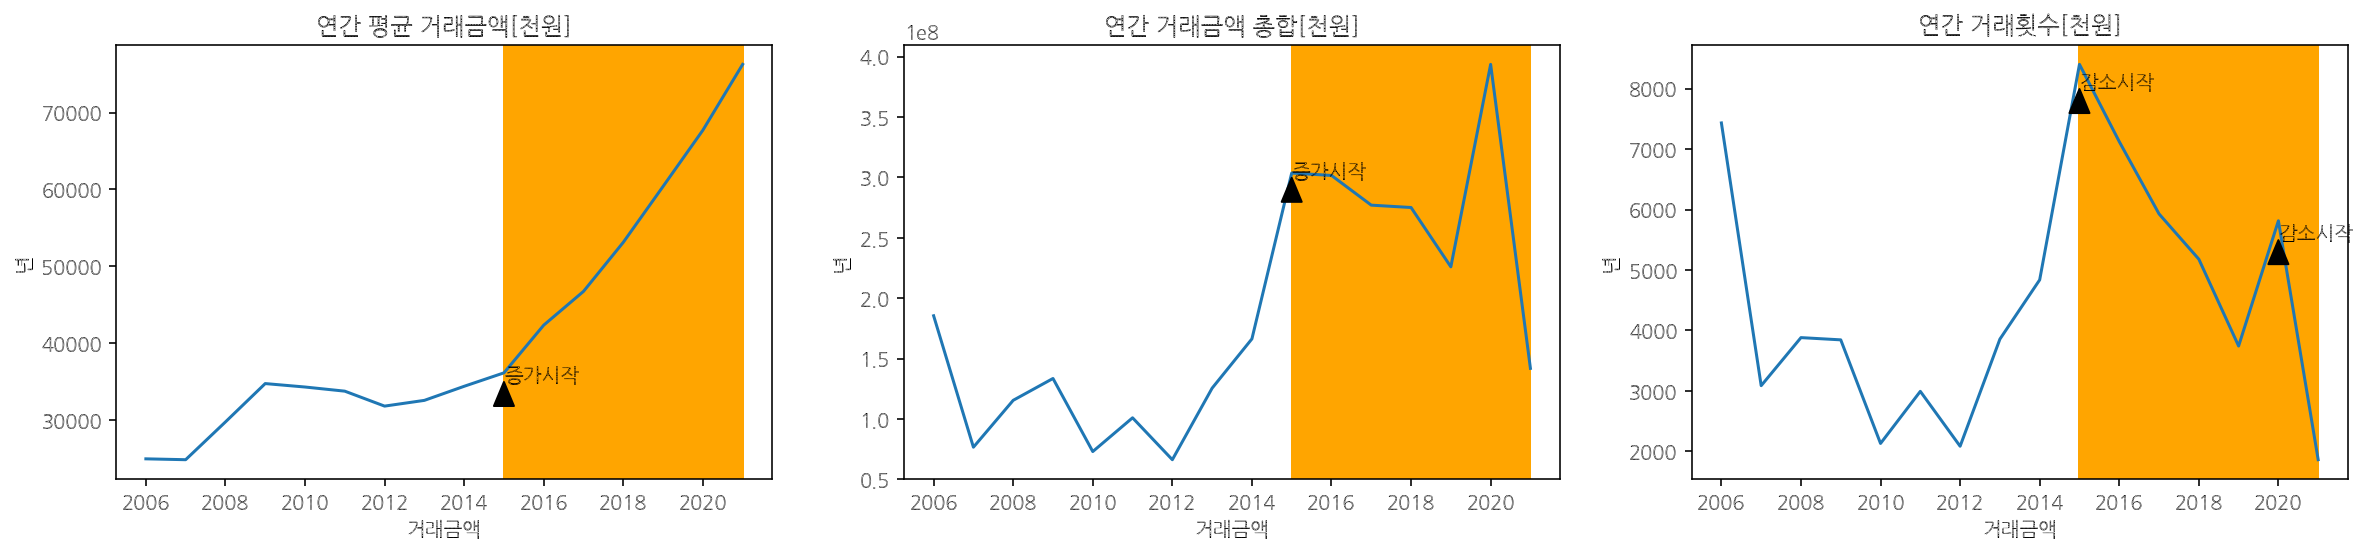

In [45]:
#@title 거래금액의 연간 평균거래금액 / 거래총액 / 거래횟수

fig = plt.figure(figsize = (20,4))
graph = fig.add_subplot


graph(1,3,1).plot(a['거래금액'].groupby('년').mean())
plt.title('연간 평균 거래금액[천원]')
plt.xlabel('거래금액')
plt.ylabel('년')
plt.annotate('증가시작',xy = (2015,35000),arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))
plt.axvspan(2015,2021,0,1,color = 'orange')


graph(1,3,2).plot(a['거래금액'].groupby('년').sum())
plt.title('연간 거래금액 총합[천원]')
plt.xlabel('거래금액')
plt.ylabel('년')
plt.annotate('증가시작',xy = (2015,300000000),arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))
plt.axvspan(2015,2021,0,1,color = 'orange')


graph(1,3,3).plot(b)
plt.title('연간 거래횟수[천원]')
plt.xlabel('거래금액')
plt.ylabel('년')
plt.annotate('감소시작',xy = (2015,8000),arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))
plt.annotate('감소시작',xy = (2020,5500),arrowprops=dict(facecolor='black', width=1, shrink=0.1, headwidth=10))
plt.axvspan(2015,2021,0,1,color = 'orange')


plt.show()

In [40]:
#@title [Selective] something to replace, using this method
def replaceMethod(df,columnName,asIsCharacter,toBeCharacter,toBeTypes):
  cleaning = df[columnName].astype(str)
  cleaning = cleaning.apply(lambda x : x.replace(asIsCharacter,toBeCharacter))
  cleaning = cleaning.astype(toBeTypes)
  return cleaning

In [41]:
rent['전용면적'] = replaceMethod(rent,'전용면적','-','.',np.float)
rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103280 entries, 0 to 103279
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   건축년도    103280 non-null  int64  
 1   년       103280 non-null  int64  
 2   법정동     103280 non-null  object 
 3   보증금액    103280 non-null  int64  
 4   아파트     103280 non-null  object 
 5   월       103280 non-null  int64  
 6   월세금액    103280 non-null  int64  
 7   일       103280 non-null  int64  
 8   전용면적    103280 non-null  float64
 9   지번      103280 non-null  object 
 10  지역코드    103277 non-null  float64
 11  층       103277 non-null  float64
 12  date    103280 non-null  object 
dtypes: float64(3), int64(6), object(4)
memory usage: 10.2+ MB


In [77]:
#@title
rent_yearly = rent[rent['월세금액'] == 0]
rent_monthly = rent[~(rent['월세금액'] == 0)]
#전세
sumation_ry = rent_yearly['보증금액'].groupby(rent_yearly['년']).sum()
mean_ry = rent_yearly['보증금액'].groupby(rent_yearly['년']).mean()
qty_ry = rent_yearly['년'].value_counts()
qty_ry = qty_ry.sort_index()
#월세
sumation_rm = rent_monthly['보증금액'].groupby(rent_monthly['년']).sum()
mean_rm = rent_monthly['보증금액'].groupby(rent_monthly['년']).mean()
qty_rm = rent_monthly['년'].value_counts()
qty_rm = qty_rm.sort_index()

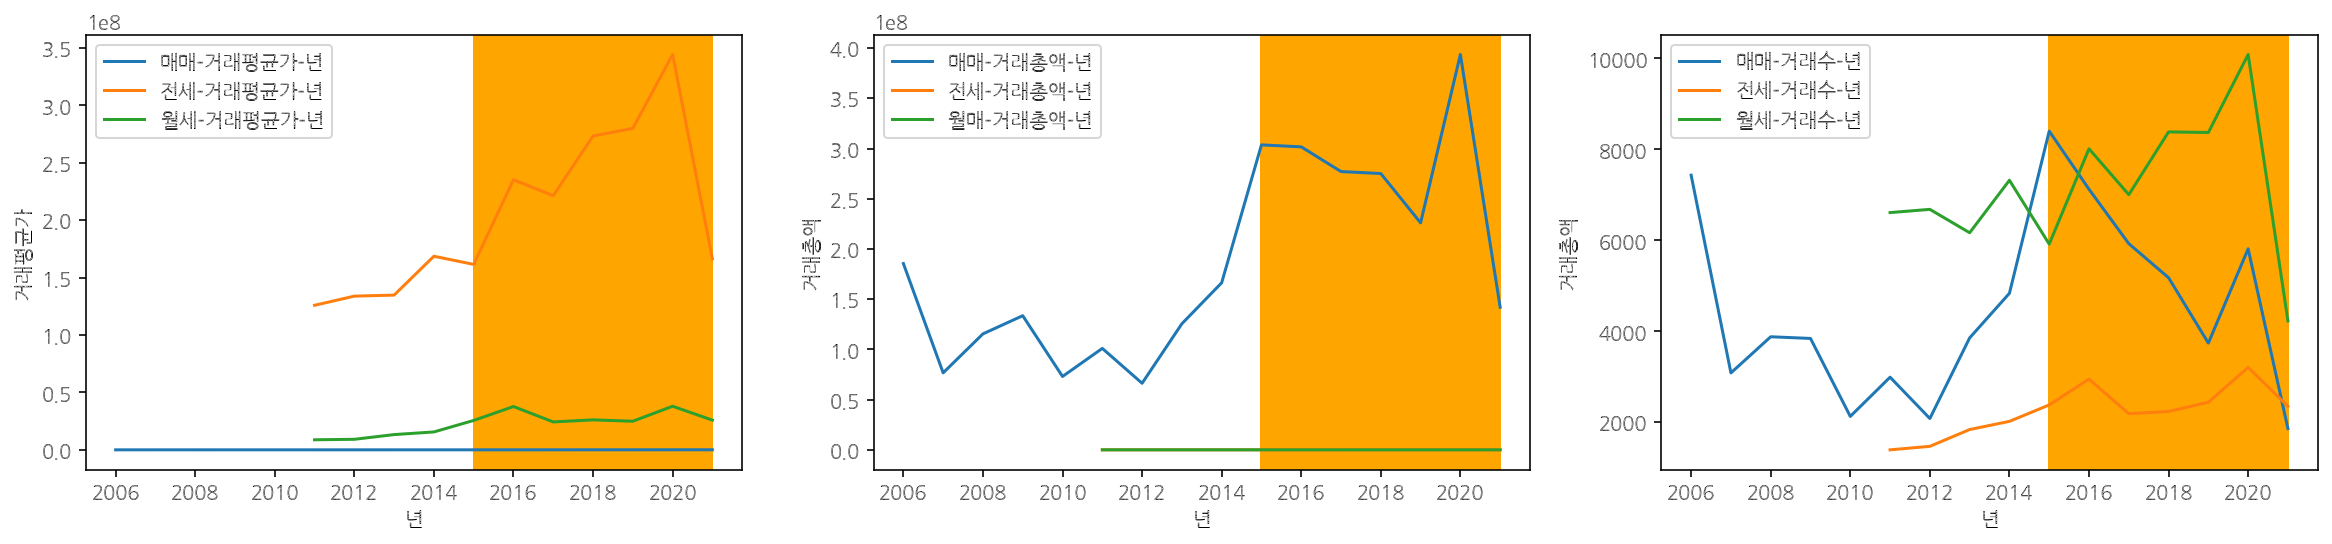

In [101]:
#@title

figg = plt.figure(figsize = (20,4))
graphh = figg.add_subplot

graphh(1,3,1).plot(a['거래금액'].groupby('년').mean(), label = '매매-거래평균가-년')
graphh(1,3,1).plot(sumation_ry,label = '전세-거래평균가-년')
graphh(1,3,1).plot(sumation_rm, label = '월세-거래평균가-년')
plt.legend(loc = 'best',ncol= 1)
plt.xlabel('년')
plt.ylabel('거래평균가')
plt.axvspan(2015,2021,0,1,color = 'orange')

graphh(1,3,2).plot(a['거래금액'].groupby('년').sum(), label = '매매-거래총액-년')
graphh(1,3,2).plot(mean_ry, label = '전세-거래총액-년')
graphh(1,3,2).plot(mean_rm, label = '월매-거래총액-년')
plt.legend(loc = 'best',ncol= 1)
plt.xlabel('년')
plt.ylabel('거래총액')
plt.axvspan(2015,2021,0,1,color = 'orange')

graphh(1,3,3).plot(b, label = '매매-거래수-년')
graphh(1,3,3).plot(qty_rm, label = '전세-거래수-년')
graphh(1,3,3).plot(qty_ry, label = '월세-거래수-년')
plt.legend(loc = 'best',ncol= 1)
plt.xlabel('년')
plt.ylabel('거래총액')
plt.axvspan(2015,2021,0,1,color = 'orange')

plt.show()


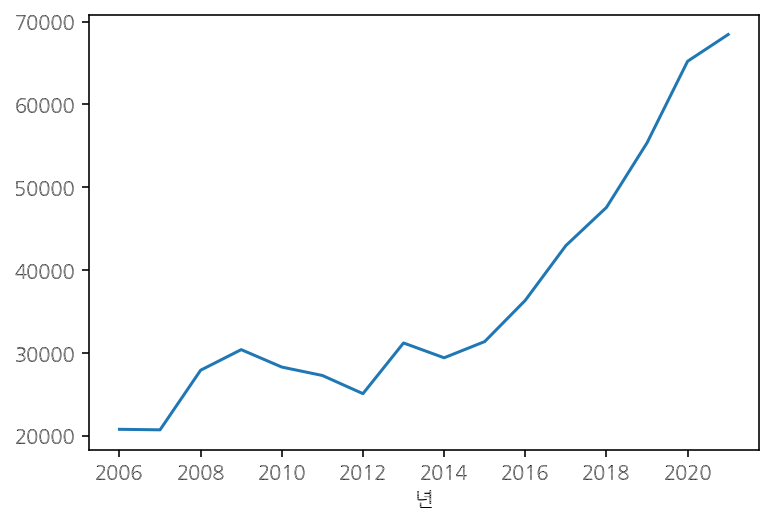

In [84]:
# rent['거래횟수'] = rent['지번'].value_counts()
trqty_rank = trade[trade['법정동'] == '가양동']['지번'].value_counts()

tmp = trade
tmp = tmp.set_index('지번')

a = tmp.loc[(trqty_rank > trqty_rank.mean()).index]


(a['거래금액'].groupby(a['년']).mean()).plot()

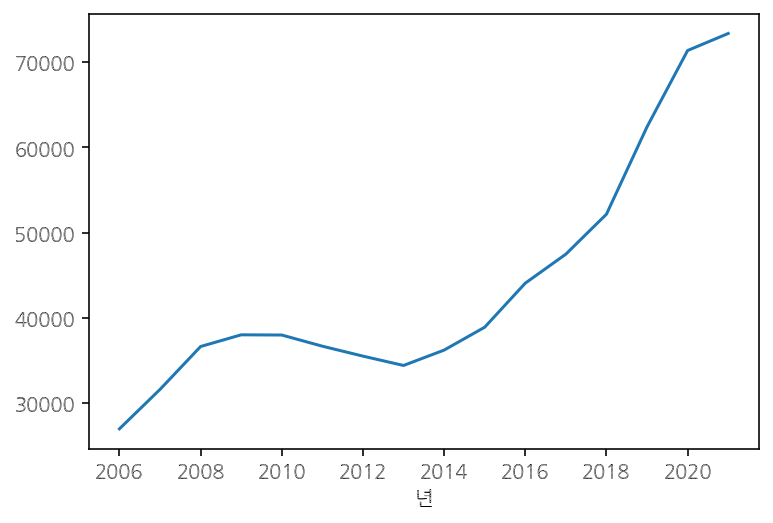

In [73]:
# rent['거래횟수'] = rent['지번'].value_counts()
#1490
trqty_rank1 = trade[trade['법정동'] == '염창동']['지번'].value_counts()

tmp1 = trade
tmp1 = tmp1.set_index('지번')

b = tmp.loc[(trqty_rank1 > trqty_rank1.mean()).index]


(b['거래금액'].groupby(b['년']).mean()).plot()

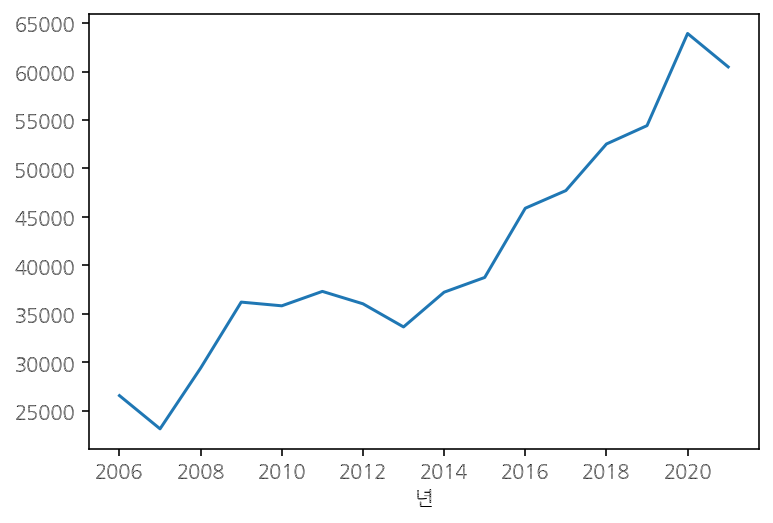

In [118]:
# rent['거래횟수'] = rent['지번'].value_counts()
#1490
trqty_rank1 = trade[trade['법정동'] == '화곡동']['지번'].value_counts()

tmp1 = trade
tmp1 = tmp1.set_index('지번')

b = tmp.loc[(trqty_rank1 > trqty_rank1.mean()).index]


(b['거래금액'].groupby(b['년']).mean()).plot()

In [ ]:
t2 = trade[trade['법정동'] == '가양동']['지번'].value_counts()
t2_raw = trade
t2_raw = t2_raw.set_index('지번')
t2_tg = t2_raw.loc[t2.index]


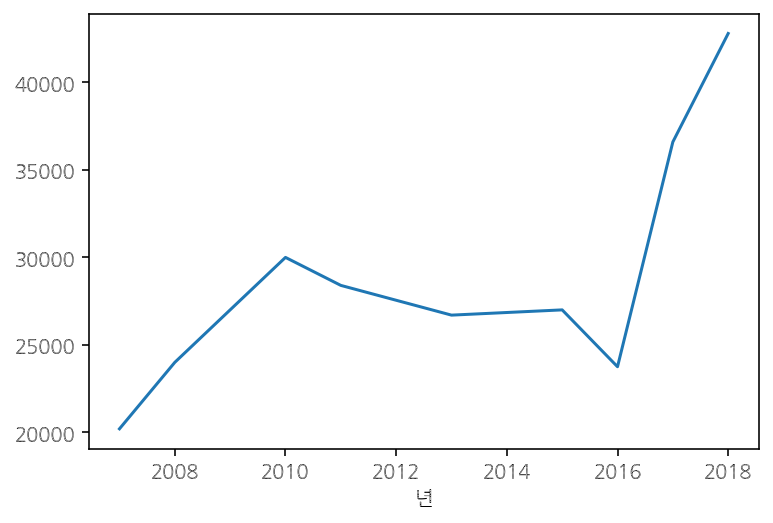

In [113]:
(trade['거래금액'].groupby(trade[trade['지번'] == '1008-30']['년']).mean()).plot()

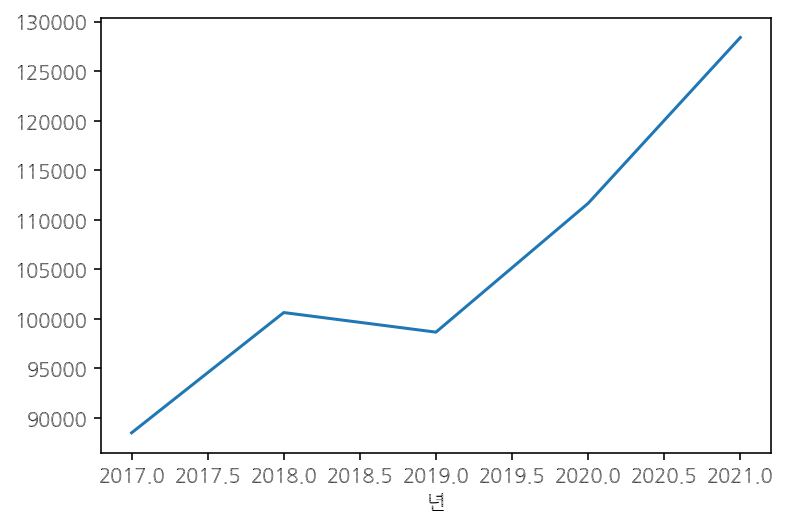

In [123]:
(trade['거래금액'].groupby(trade[trade['지번'] == '748']['년']).mean()).plot()

In [125]:
trade[trade['지번'] == '748']['아파트']

55010    마곡13단지힐스테이트마스터
55014    마곡13단지힐스테이트마스터
56731    마곡13단지힐스테이트마스터
56753    마곡13단지힐스테이트마스터
56755    마곡13단지힐스테이트마스터
              ...      
72130    마곡13단지힐스테이트마스터
72131    마곡13단지힐스테이트마스터
72133    마곡13단지힐스테이트마스터
72134    마곡13단지힐스테이트마스터
72138    마곡13단지힐스테이트마스터
Name: 아파트, Length: 213, dtype: object